# Что не сработало

Попробовал использовать torch_geometric для решения задачи, сделал достаточно сложные архитектуры, но модель работала хуже бейзлайна

In [25]:
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

# Test graph

In [26]:
import os
from copy import deepcopy

import dgl.nn.pytorch as dglnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from dgl.nn import GATConv, GraphConv
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE
from torch.nn import Linear
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    ChebConv,
    GATConv,
    GCNConv,
    GraphConv,
    NNConv,
    global_mean_pool,
)
from tqdm import tqdm

np.set_printoptions(suppress=True)

In [27]:
df = pd.read_excel("02-pdbbind-refined.xlsx", engine="openpyxl")

In [28]:
df["e_predict"] = df["e_exp"] * 2 ** (-(df["rmsd"] ** 2) / 4)

In [29]:
df["e_predict"] = df["e_predict"].map(lambda x: abs(x))

In [30]:
df.head()

,pdb,run,pose,nfrb,e_docking,rmsd,eLJ,emetal,eHB,eelec,etors,is_good,e_exp,name,e_predict
0,184l,0,0,2,-5.32687,0.55437,-1.41440,0.0,0.20612,-0.00003,0.2352,1,-6.444844,184l-0-0.gml,6.110599
1,184l,0,1,2,-5.15635,1.80368,-1.34504,0.0,0.26135,-0.00049,0.2352,0,-6.444844,184l-0-1.gml,3.667584
2,184l,0,2,2,-5.03622,4.19935,-1.37091,0.0,0.36299,0.00039,0.2352,0,-6.444844,184l-0-2.gml,0.303446
3,184l,0,3,2,-5.05864,4.24878,-1.40106,0.0,0.37758,0.00002,0.2352,0,-6.444844,184l-0-3.gml,0.282263
4,184l,0,4,2,-5.12396,4.24426,-1.41376,0.0,0.21307,-0.00005,0.2352,0,-6.444844,184l-0-4.gml,0.284147


In [6]:
data = np.load("data/1a28-2-0.npz")

In [7]:
data["node_data"]

array([[460.,   3.,   0.,   0.,   0.],
       [471.,   3.,   0.,   0.,   0.],
       [492.,   0.,   0.,   0.,   0.],
       ...,
       [ 20.,   0.,   1.,   1.,   0.],
       [ 21.,   3.,   1.,   1.,   0.],
       [ 22.,   0.,   1.,   1.,   0.]])

In [31]:
folder = "data/"
node_ohe = OHE(categories=[list(range(23)), [0, 1], [0, 1]])
edge_ohe = OHE(categories=[[0, 1]])
graphs = []
idx_arr = []
y_arr = []

In [32]:
for num, fn in enumerate(os.listdir(folder)):
    if fn.endswith(".npz"):
        data = np.load(folder + fn)
        X = torch.tensor(node_ohe.fit_transform(data["node_data"][:, 1:4]).todense())

        A = edge_ohe.fit_transform(data["edge_data"][:, 1:]).todense()
        E = torch.tensor(np.hstack((data["edge_data"][:, :1], A)))

        pg_data = Data(
            edge_index=torch.tensor(data["edges"][:, 0:2]).t().contiguous().long(),
            x=X.float(),
            edge_attr=E.float(),
            y=torch.tensor(
                df[df["name"] == fn.replace(".npz", ".gml")]["e_predict"].item()
            ),
        )

        idx_arr.append(num)
        y_arr.append(df[df["name"] == fn.replace(".npz", ".gml")]["e_predict"].item())

        graphs.append(pg_data)

In [10]:
# import compress_pickle
# compress_pickle.dump(graphs, "data/graphs.pkl")

# Train/test split, Dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    graphs,
    y_arr,
    test_size=0.2,
    random_state=42,
    stratify=[np.exp(i.y.cpu().numpy()) > 0.5 for i in graphs],
)

In [13]:
class GraphDataset(Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph_data = self.graphs[idx]

        graph_data.y_exp = torch.exp(deepcopy(graph_data.y))

        graph_data.y_int = torch.round(deepcopy(graph_data.y_exp)).float()

        return graph_data

In [14]:
train_dataset = GraphDataset(X_train)
test_dataset = GraphDataset(X_test)

In [15]:
train_dataset[0]

Data(x=[517, 27], edge_index=[2, 22851], edge_attr=[22851, 3], y=0.15911602973937988, y_exp=1.1724740266799927, y_int=1.0)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=6)

In [17]:
def baseline_model(train_dataset, test_dataset):
    criterion = nn.MSELoss(reduction="mean")

    prediction = np.mean([i.y.item() for i in train_dataset])

    true_labels = [i.y.item() for i in test_dataset]
    pred_labels = [prediction for i in range(len(test_dataset))]

    return (
        mean_squared_error(pred_labels, true_labels, squared=True),
        r2_score(pred_labels, true_labels),
        criterion(torch.tensor(pred_labels), torch.tensor(true_labels)).item(),
    )

In [18]:
baseline_model(train_dataset, test_dataset)

(8.563990328446478, -4.3424589920815715e+31, 8.563990328446478)

Бейзлайн модель при текущем сплите отрабатывает на 8.564 RMSE

## Простая графовая регрессионная модель pytorch_geometric без использования edge_features

In [30]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GraphConv, NNConv, global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, node_feature_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(node_feature_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 30)
        self.lin2 = Linear(30, 1)

    def forward(self, data):
        # 1. Obtain node embeddings
        x, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch,
        )
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x


model = GCN(hidden_channels=64, node_feature_channels=train_dataset.num_node_features)
print(model)
print(sum(p.numel() for p in model.parameters()))  # Не очень тяжелая модель

GCN(
  (conv1): GraphConv(27, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)
22013


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
device = "cuda:2"
model = model.to(device)


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out.view(-1, 1), data.y.view(-1, 1))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    print(f"Train loss: {loss.item()}")

    with torch.no_grad():
        true = []
        preds = []
        for data in test_loader:  # Iterate in batches over the training dataset.
            data = data.to(device)
            out = model(data)  # Perform a single forward pass.
            val_loss = criterion(
                out.view(-1, 1), data.y.view(-1, 1)
            )  # Compute the loss.
            true.extend(data.y.detach().cpu().numpy())
            preds.extend(out.detach().cpu().numpy())
        print(f"Validation loss: {val_loss.item()}")

    return mean_squared_error(true, preds)


rmse_history = []
for epoch in range(100):
    rmse_val = train()
    rmse_history.append(rmse_val)

Train loss: 4.837188720703125
Validation loss: 4.703821659088135
Train loss: 1.321024775505066
Validation loss: 0.21944275498390198
Train loss: 3.3927693367004395
Validation loss: 3.650869369506836
Train loss: 7.441938400268555
Validation loss: 9.835693359375
Train loss: 1.2197413444519043
Validation loss: 0.7655764818191528
Train loss: 1.7650243043899536
Validation loss: 2.459132432937622
Train loss: 5.909269332885742
Validation loss: 2.240975856781006
Train loss: 16.18610954284668
Validation loss: 5.481194496154785
Train loss: 3.1364128589630127
Validation loss: 0.27945929765701294
Train loss: 0.739136278629303
Validation loss: 3.129793643951416
Train loss: 8.18210220336914
Validation loss: 0.4520628750324249
Train loss: 6.439365863800049
Validation loss: 1.3088550567626953
Train loss: 0.4992656707763672
Validation loss: 5.411246299743652
Train loss: 0.08013726770877838
Validation loss: 12.450654029846191
Train loss: 0.2558259069919586
Validation loss: 4.587270736694336
Train loss: 1

(3.0, 20.0)

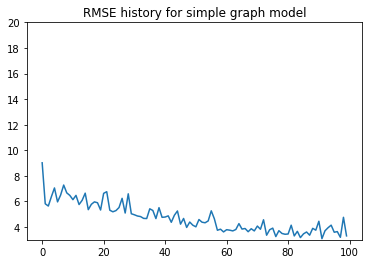

In [39]:
plt.plot(rmse_history)
plt.title("RMSE history for simple graph model")
plt.ylim([3, 20])

В целом простая модель долго и тяжело сходится, бейзлайн слегка пробит <br>
upd. Модель сходится до ~2.2 RMSE после 600+ эпох

In [40]:
min(rmse_history)

3.0883672

# Heavy model тяжелые модели, которые используют edge_features работают хуже

In [41]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import (
    ChebConv,
    DeepGCNLayer,
    GCNConv,
    GraphConv,
    NNConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)

In [43]:
class MapE2NxN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(MapE2NxN, self).__init__()
        self.linear1 = Linear(in_channels, hidden_channels)
        self.linear2 = Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.linear1(x)
        x = x.relu()
        x = self.linear2(x)
        return x


class MyDeeperGCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features,
        num_edge_features,
        node_hidden_channels,
        edge_hidden_channels,
        num_layers,
        num_classes,
    ):
        super(MyDeeperGCN, self).__init__()

        self.node_encoder = GraphConv(num_node_features, node_hidden_channels)
        self.edge_encoder = Linear(num_edge_features, edge_hidden_channels)

        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = NNConv(
                node_hidden_channels,
                node_hidden_channels,
                MapE2NxN(
                    edge_hidden_channels,
                    node_hidden_channels * node_hidden_channels,
                    64,
                ),
            )
            norm = nn.LayerNorm(node_hidden_channels)
            act = nn.ELU(inplace=True)

            layer = DeepGCNLayer(
                conv, norm, act, block="res+", dropout=0, ckpt_grad=False
            )
            self.layers.append(layer)

        self.lin1 = Linear(node_hidden_channels, 30)
        self.lin2 = Linear(30, 15)
        self.lin3 = Linear(15, num_classes)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        # edge for paired nodes are excluded for encoding node
        x = self.node_encoder(x, edge_index)  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        edge_attr = self.edge_encoder(edge_attr)

        x = self.layers[0].conv(x, edge_index, edge_attr)

        for layer in self.layers[1:]:
            x = layer(x, edge_index, edge_attr)

        x = self.layers[0].norm(x)

        x = global_mean_pool(x, batch)

        x = self.lin1(x)

        x = F.elu(x)

        x = self.lin2(x)

        x = F.elu(x)

        return self.lin3(x)


model = MyDeeperGCN(
    train_dataset.num_node_features,
    train_dataset.num_edge_features,
    node_hidden_channels=64,
    edge_hidden_channels=64,
    num_layers=3,
    num_classes=1,
)
print(model)
print(sum(p.numel() for p in model.parameters()))  # Внушительная модель

MyDeeperGCN(
  (node_encoder): GraphConv(27, 64)
  (edge_encoder): Linear(in_features=3, out_features=64, bias=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
  )
  (lin1): Linear(in_features=64, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=15, bias=True)
  (lin3): Linear(in_features=15, out_features=1, bias=True)
)
830271


In [44]:
# Добавил scaler и mixed precision
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=5e-4)
criterion = nn.MSELoss(reduction="sum")
device = "cuda:2"
model = model.to(device)


def train(loader):
    model.train()
    true_labels = []
    pred_labels = []
    with torch.cuda.amp.autocast():
        for data in loader:  # Iterate in batches over the training dataset.

            out = model(data.to(device))  # Perform a single forward pass.
            loss = criterion(out.view(-1, 1), data.y.view(-1, 1))  # Compute the loss.
            scaler.scale(loss).backward()  # Derive gradients.
            # loss.backward()
            scaler.step(optimizer)  # Update parameters based on gradients.
            # optimizer.step()
            scaler.update()
            optimizer.zero_grad()  # Clear gradients.

            true_labels.extend(data.y.detach().cpu().numpy())
            pred_labels.extend(out.detach().cpu().numpy())

    print(f"Train Accuracy: {loss.item()}, EPOCH: {epoch}")

    return loss.item(), mean_squared_error(true_labels, pred_labels)


def test(loader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            for data in loader:  # Iterate in batches over the training/test dataset.
                out = model(data.to(device))
                val_loss = criterion(out.view(-1, 1), data.y.view(-1, 1))

                true_labels.extend(data.y.detach().cpu().numpy())
                pred_labels.extend(out.detach().cpu().numpy())

    print(f"Validation Accuracy: {val_loss.item()}, EPOCH: {epoch}")
    return val_loss.item(), mean_squared_error(true_labels, pred_labels)


losses_d = {"train": [], "val": [], "train_rmse": [], "val_rmse": []}

for epoch in range(100):
    train_loss, train_rmse = train(train_loader)
    val_loss, test_rmse = test(test_loader)

    losses_d["train"].append(train_loss)
    losses_d["val"].append(val_loss)
    losses_d["train_rmse"].append(train_rmse)
    losses_d["val_rmse"].append(test_rmse)

Train Accuracy: 87.17100524902344, EPOCH: 0
Validation Accuracy: 3.8768470287323, EPOCH: 0
Train Accuracy: 3.274113893508911, EPOCH: 1
Validation Accuracy: 7.661032199859619, EPOCH: 1
Train Accuracy: 19.66990852355957, EPOCH: 2
Validation Accuracy: 55.43294143676758, EPOCH: 2
Train Accuracy: 4.710487365722656, EPOCH: 3
Validation Accuracy: 52.21293640136719, EPOCH: 3
Train Accuracy: 11.187816619873047, EPOCH: 4
Validation Accuracy: 6.224162578582764, EPOCH: 4
Train Accuracy: 4.695056438446045, EPOCH: 5
Validation Accuracy: 7.767773628234863, EPOCH: 5
Train Accuracy: 3.8167476654052734, EPOCH: 6
Validation Accuracy: 6.035558223724365, EPOCH: 6
Train Accuracy: 4.211737632751465, EPOCH: 7
Validation Accuracy: 18.66333770751953, EPOCH: 7
Train Accuracy: 53.283477783203125, EPOCH: 8
Validation Accuracy: 42.96971893310547, EPOCH: 8
Train Accuracy: 3.2188210487365723, EPOCH: 9
Validation Accuracy: 22.6881046295166, EPOCH: 9
Train Accuracy: 14.141031265258789, EPOCH: 10
Validation Accuracy: 3.

ValueError: Input contains NaN, infinity or a value too large for dtype('float16').

In [45]:
[(i, min(losses_d[i])) for i in losses_d]

[('train', 2.50496244430542),
 ('val', 1.0628594160079956),
 ('train_rmse', 7.292406),
 ('val_rmse', 8.242118)]

Хуже бейзлайна

In [63]:
# Возможно, scaler и mixed precision всё ломают...
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=5e-4)
criterion = nn.MSELoss(reduction="sum")
device = "cuda:2"
model = MyDeeperGCN(
    train_dataset.num_node_features,
    train_dataset.num_edge_features,
    node_hidden_channels=64,
    edge_hidden_channels=64,
    num_layers=3,
    num_classes=1,
)
model = model.to(device)


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out.view(-1, 1), data.y.view(-1, 1))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    print(f"Train loss: {loss.item()}")

    with torch.no_grad():
        true = []
        preds = []
        for data in test_loader:  # Iterate in batches over the training dataset.
            data = data.to(device)
            out = model(data)  # Perform a single forward pass.
            val_loss = criterion(
                out.view(-1, 1), data.y.view(-1, 1)
            )  # Compute the loss.
            true.extend(data.y.detach().cpu().numpy())
            preds.extend(out.detach().cpu().numpy())
        print(f"Validation loss: {val_loss.item()}")

    return mean_squared_error(true, preds)


rmse_history = []
for epoch in range(100):
    rmse_val = train()
    rmse_history.append(rmse_val)

Train loss: 0.004145525395870209
Validation loss: 6.749276161193848
Train loss: 0.6910750269889832
Validation loss: 7.386547088623047
Train loss: 55.16569519042969
Validation loss: 0.013981571421027184
Train loss: 0.00685677956789732
Validation loss: 10.361148834228516
Train loss: 0.43512243032455444
Validation loss: 0.10570701956748962
Train loss: 30.593734741210938
Validation loss: 33.584102630615234
Train loss: 14.447463989257812
Validation loss: 18.585309982299805
Train loss: 16.565887451171875
Validation loss: 0.8509278297424316
Train loss: 67.62338256835938
Validation loss: 59.572933197021484
Train loss: 0.24486319720745087
Validation loss: 101.80974578857422
Train loss: 0.22299863398075104
Validation loss: 4.253596782684326
Train loss: 2.8511979579925537
Validation loss: 111.56334686279297
Train loss: 53.951438903808594
Validation loss: 41.51873779296875
Train loss: 0.15356935560703278
Validation loss: 1.7616194486618042
Train loss: 0.9798112511634827
Validation loss: 0.01970004

(3.0, 20.0)

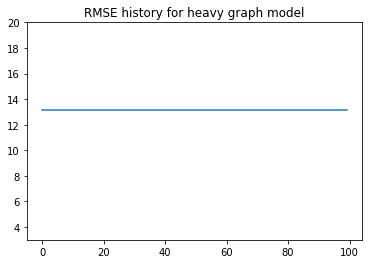

In [64]:
plt.plot(rmse_history)
plt.title("RMSE history for heavy graph model")
plt.ylim([3, 20])

Нет, без scaler и mixed_precision всё еще хуже

# Simple non-graph model

In [112]:
class GraphDataset(Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph_data = self.graphs[idx]

        graph_data.y_exp = torch.exp(deepcopy(graph_data.y))

        graph_data.y_int = torch.round(deepcopy(graph_data.y_exp)).float()

        return F.pad(graph_data.x, (0, 0, 538 - graph_data.x.shape[0], 0)), graph_data.y

In [113]:
train_dataset = GraphDataset(X_train)
test_dataset = GraphDataset(X_test)

In [115]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=6)

In [122]:
x.shape

torch.Size([2, 538, 27])

In [132]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        torch.manual_seed(12345)
        self.node1 = Linear(27, 30)
        self.node2 = Linear(30, 30)
        self.node3 = Linear(30, 1)

        self.lin1 = Linear(538, 250)
        self.lin2 = Linear(250, 125)
        self.lin3 = Linear(125, 50)
        self.lin4 = Linear(50, 1)

    def forward(self, x):
        # 1. Obtain node embeddings

        x = self.node1(x)
        x = x.relu()
        x = self.node2(x)
        x = x.relu()
        x = self.node3(x)

        x = torch.flatten(x, start_dim=1)

        emb = self.lin1(x)
        emb = emb.relu()
        emb = self.lin2(emb)
        emb = emb.relu()
        emb = self.lin3(emb)
        emb = emb.relu()
        emb = self.lin4(emb)

        return emb


model = SimpleNet()
print(model)
print(sum(p.numel() for p in model.parameters()))

SimpleNet(
  (node1): Linear(in_features=27, out_features=30, bias=True)
  (node2): Linear(in_features=30, out_features=30, bias=True)
  (node3): Linear(in_features=30, out_features=1, bias=True)
  (lin1): Linear(in_features=538, out_features=250, bias=True)
  (lin2): Linear(in_features=250, out_features=125, bias=True)
  (lin3): Linear(in_features=125, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=1, bias=True)
)
174277


In [136]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss(reduction="sum")
device = "cuda:2"
model = model.to(device)


def train():
    model.train()

    for data, y in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        y = y.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out.view(-1, 1), y.view(-1, 1))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    print(f"Train loss: {loss.item()}")

    with torch.no_grad():
        true = []
        preds = []
        for data, y in test_loader:  # Iterate in batches over the training dataset.
            data = data.to(device)
            y = y.to(device)
            out = model(data)  # Perform a single forward pass.
            val_loss = criterion(out.view(-1, 1), y.view(-1, 1))  # Compute the loss.
            true.extend(y.detach().cpu().numpy())
            preds.extend(out.detach().cpu().numpy())
        print(f"Validation loss: {val_loss.item()}")

    return mean_squared_error(true, preds)


rmse_history = []
for epoch in range(100):
    rmse_val = train()
    rmse_history.append(rmse_val)

Train loss: 0.0018012098735198379
Validation loss: 9.810657501220703
Train loss: 0.0006994596333242953
Validation loss: 3.1569535732269287
Train loss: 0.036039017140865326
Validation loss: 7.76141357421875
Train loss: 0.008190817199647427
Validation loss: 0.9339948296546936
Train loss: 0.01852126233279705
Validation loss: 7.070501804351807
Train loss: 0.024220522493124008
Validation loss: 72.6246109008789
Train loss: 0.00018819286196958274
Validation loss: 0.031264081597328186
Train loss: 0.6099826693534851
Validation loss: 0.3196589946746826
Train loss: 0.01178784854710102
Validation loss: 0.16399696469306946
Train loss: 0.13650275766849518
Validation loss: 0.20345750451087952
Train loss: 0.1401083767414093
Validation loss: 20.592247009277344
Train loss: 0.0249974112957716
Validation loss: 0.8318202495574951
Train loss: 0.012425193563103676
Validation loss: 0.24594053626060486
Train loss: 0.10870187729597092
Validation loss: 2.367341995239258
Train loss: 0.001739142811857164
Validatio

(3.0, 20.0)

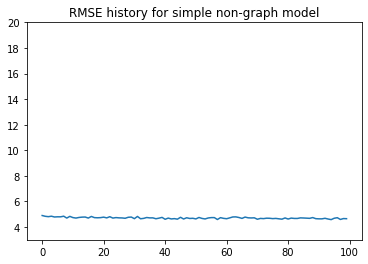

In [137]:
plt.plot(rmse_history)
plt.title("RMSE history for simple non-graph model")
plt.ylim([3, 20])

In [138]:
min(rmse_history)

4.578388

Очень медленная и плохая сходимость на +- уровень бейзлайна

# GRU - вариант очень большой сети, учитывающей edge_attrs

In [19]:
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential
from torch_geometric.nn import NNConv, Set2Set

device = "cuda:2"


class MPNNet(torch.nn.Module):
    def __init__(self, node_feats, channels, out_feats, loops=1, edge_feats=1):
        super(MPNNet, self).__init__()
        self.lin0 = torch.nn.Linear(node_feats, channels)
        self.loops = loops
        nn = Sequential(
            Linear(edge_feats, channels), ReLU(), Linear(channels, channels * channels)
        )
        self.conv = NNConv(channels, channels, nn, aggr="mean")
        self.gru = GRU(channels, channels)
        self.set2set = Set2Set(channels, 1)

        self.lin1 = torch.nn.Linear(channels * 2, channels)
        self.lin2 = torch.nn.Linear(channels, out_feats)

    def forward(self, data):
        out = F.relu(self.lin0(data.x.float()))
        h = out.unsqueeze(0)

        for i in range(self.loops):
            m = F.relu(
                self.conv(out.float(), data.edge_index.long(), data.edge_attr.float())
            )
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out

In [20]:
node_feats = train_dataset.num_node_features
out_feats = 1
edge_feats = train_dataset.num_edge_features


# model = GCNNet(node_feats,256,out_feats,edge_feats=edge_feats).double().to(device)
model = MPNNet(node_feats, 128, out_feats, loops=10, edge_feats=edge_feats).float()
print(sum(p.numel() for p in model.parameters()))

2463873


In [21]:
model

MPNNet(
  (lin0): Linear(in_features=27, out_features=128, bias=True)
  (conv): NNConv(128, 128, aggr="mean", nn=Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
  ))
  (gru): GRU(128, 128)
  (set2set): Set2Set(128, 256)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
)

In [22]:
model = model.to(device)

In [23]:
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=5e-4)
criterion = nn.MSELoss(reduction="sum")
device = "cuda:2"


def train(loader):
    model.train()
    true_labels = []
    pred_labels = []
    with torch.cuda.amp.autocast():
        for data in loader:  # Iterate in batches over the training dataset.

            out = model(data.to(device))  # Perform a single forward pass.
            loss = criterion(out.view(-1, 1), data.y.view(-1, 1))  # Compute the loss.
            scaler.scale(loss).backward()  # Derive gradients.
            scaler.step(optimizer)  # Update parameters based on gradients.
            scaler.update()
            optimizer.zero_grad()  # Clear gradients.

            true_labels.extend(data.y.detach().cpu().numpy())
            pred_labels.extend(out.detach().cpu().numpy())

    print(
        f"Train Accuracy: {loss.item()}, EPOCH: {epoch}, rmse {mean_squared_error(true_labels, pred_labels)}"
    )

    return loss.item(), mean_squared_error(true_labels, pred_labels)


def test(loader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            for data in loader:  # Iterate in batches over the training/test dataset.
                out = model(data.to(device))
                val_loss = criterion(out.view(-1, 1), data.y.view(-1, 1))

                true_labels.extend(data.y.detach().cpu().numpy())
                pred_labels.extend(out.detach().cpu().numpy())

    print(
        f"Validation Accuracy: {val_loss.item()}, EPOCH: {epoch}, rmse {mean_squared_error(true_labels, pred_labels)}"
    )
    return val_loss.item(), mean_squared_error(true_labels, pred_labels)


losses_d = {"train": [], "val": [], "train_rmse": [], "val_rmse": []}

for epoch in range(100):
    train_loss, train_rmse = train(train_loader)
    val_loss, test_rmse = test(test_loader)

    losses_d["train"].append(train_loss)
    losses_d["val"].append(val_loss)
    losses_d["train_rmse"].append(train_rmse)
    losses_d["val_rmse"].append(test_rmse)

Train Accuracy: 96.58198547363281, EPOCH: 0, rmse 10.253569602966309
Validation Accuracy: 0.864886462688446, EPOCH: 0, rmse 9.822648048400879
Train Accuracy: 1.5249669551849365, EPOCH: 1, rmse 8.165838241577148
Validation Accuracy: 2.3352818489074707, EPOCH: 1, rmse 8.906861305236816
Train Accuracy: 5.291328430175781, EPOCH: 2, rmse 7.641041278839111
Validation Accuracy: 3.614690065383911, EPOCH: 2, rmse 8.542835235595703
Train Accuracy: 4.628066539764404, EPOCH: 3, rmse 7.5419416427612305
Validation Accuracy: 0.576270341873169, EPOCH: 3, rmse 8.520788192749023
Train Accuracy: 7.228550434112549, EPOCH: 4, rmse 7.524672031402588
Validation Accuracy: 75.2681655883789, EPOCH: 4, rmse 8.497868537902832
Train Accuracy: 24.049753189086914, EPOCH: 5, rmse 7.482661724090576
Validation Accuracy: 42.1541748046875, EPOCH: 5, rmse 9.975358009338379
Train Accuracy: 5.114821434020996, EPOCH: 6, rmse 7.428972244262695
Validation Accuracy: 43.04279327392578, EPOCH: 6, rmse 8.4843168258667
Train Accura

KeyboardInterrupt: 

Производительность не очень хорошая для такой большой модели, слегка лучше бейзлайна

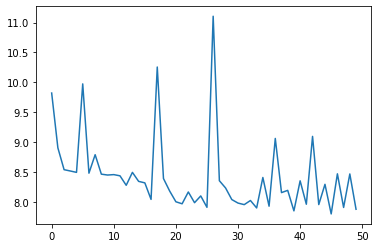

In [24]:
plt.plot(losses_d["val_rmse"])